In [1]:
import dolfinx
from mpi4py import MPI
print(dolfinx.__version__)

0.9.0


In [1]:
import gmsh
from mpi4py import MPI
import numpy as np
from dolfinx import mesh, fem, io
import ufl
from petsc4py import PETSc
import pyvista

# 1. Generate mesh with Gmsh
R = 0.1
square_size = 0.5
lc = 0.05  # Mesh size parameter

gmsh.initialize()
gmsh.model.add("square_with_circle")

# Outer rectangle
rect = gmsh.model.occ.addRectangle(-square_size, -square_size, 0, 2*square_size, 2*square_size)

# Inner circle
circ = gmsh.model.occ.addDisk(0,0,0, R, R)

# Create a plane surface with a hole
gmsh.model.occ.cut([(2, rect)], [(2, circ)], removeTool=False)
gmsh.model.occ.synchronize()

# Physical groups for boundaries
gmsh.model.addPhysicalGroup(1, [1], tag=1)  # Circle boundary
gmsh.model.addPhysicalGroup(1, [2,3,4,5], tag=2)  # Rectangle boundary edges
gmsh.model.addPhysicalGroup(2, [1], tag=1)  # Surface

# Mesh generation
gmsh.model.mesh.generate(2)

# Convert to Dolfinx mesh
msh, cell_tags, facet_tags = io.gmshio.model_to_mesh(
    gmsh.model, MPI.COMM_WORLD, 0, gdim=2
)

gmsh.finalize()



Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00207044s, CPU 0.002747s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0123023s, CPU 0.016627s)
Info    : 118 nodes 246 elements


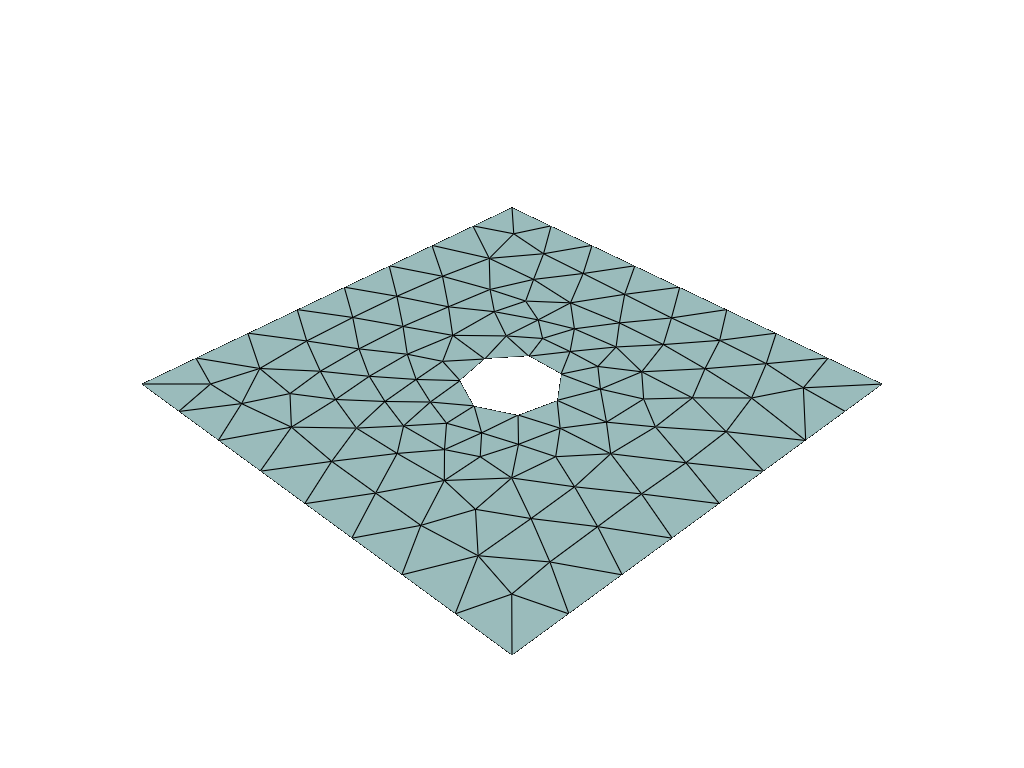

In [68]:
# After msh is created
topology, cell_types, geometry = dolfinx.plot.vtk_mesh(msh, msh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show(title="Mesh")

In [20]:
# 2. Function space
V = fem.functionspace(msh, ("CG", 1))


In [22]:
# 3. Boundary conditions
# Helper for locating top and bottom boundaries
def on_top(x):
    return np.isclose(x[1], square_size)
def on_bottom(x):
    return np.isclose(x[1], -square_size)

u_0 = fem.Constant(msh, PETSc.ScalarType(0.0))
u_T = fem.Constant(msh, PETSc.ScalarType(0.2))
u_B = fem.Constant(msh, PETSc.ScalarType(0.1))

bc_T_0 = fem.dirichletbc(u_0, fem.locate_dofs_geometrical(V, on_top), V)
bc_B_0 = fem.dirichletbc(u_0, fem.locate_dofs_geometrical(V, on_bottom), V)
bc_T_1 = fem.dirichletbc(u_T, fem.locate_dofs_geometrical(V, on_top), V)
bc_B_1 = fem.dirichletbc(u_B, fem.locate_dofs_geometrical(V, on_bottom), V)


In [23]:

# 4. Mark internal boundary (circle)
facet_indices, facet_markers = [], []
f = mesh.exterior_facet_indices(msh.topology)
x = msh.geometry.x

for i in f:
    facet = msh.topology.connectivity(1, 0).links(i)
    pts = x[facet]
    bary = np.mean(pts, axis=0)
    r = np.sqrt(bary[0]**2 + bary[1]**2)
    if np.isclose(r, R, atol=0.1*R):
        facet_indices.append(i)
        facet_markers.append(1)

internal_marker = mesh.meshtags(msh, 1, np.array(facet_indices, dtype=np.int32), np.array(facet_markers, dtype=np.int32))

# Create measure over internal facets
dS = ufl.Measure("dS", domain=msh, subdomain_data=internal_marker)


In [25]:

# 5. Variational problem
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define piecewise epsilon with conditional expression
x = ufl.SpatialCoordinate(msh)
eps1 = 1.0
eps2 = 10.0
epsilon = ufl.conditional(ufl.lt(x[0]**2 + x[1]**2, R**2), eps1, eps2)

sigma = fem.Constant(msh, PETSc.ScalarType(1.0))
rho = fem.Constant(msh, PETSc.ScalarType(0.0))

a = ufl.inner(epsilon * ufl.grad(u), ufl.grad(v)) * ufl.dx
L0 = rho * v * ufl.dx + sigma * v('-') * dS(1)
L1 = fem.Constant(msh, PETSc.ScalarType(0.0)) * v * ufl.dx


In [26]:

# 6. Solve problem 0
problem0 = fem.petsc.LinearProblem(
    a, L0, bcs=[bc_T_0, bc_B_0], petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
sol0 = problem0.solve()



ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored


In [29]:
# Solve problem 1
problem1 = fem.petsc.LinearProblem(
    a, L1, bcs=[bc_T_1, bc_B_1], petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
sol1 = problem1.solve()

ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored


In [46]:
# 7. Compute electric field
# V_E = fem.VectorFunctionSpace(msh, ("CG", 1))  # 2D vector field
grad_sum = -epsilon * ufl.grad(sol0 + sol1)
# E_expr = fem.Expression(grad_sum, V_E.element.interpolation_points())
# E = fem.Function(V_E)
# E.interpolate(E_expr)

In [59]:
grad_sum_expr = ufl.as_tensor([grad_sum[0], grad_sum[1]])
V_E = fem.functionspace(msh, ("Lagrange", 1, (msh.geometry.dim,)))
E_expr = fem.Expression(grad_sum_expr, V_E.element.interpolation_points())
E = fem.Function(V_E)
E.interpolate(E_expr)


ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored


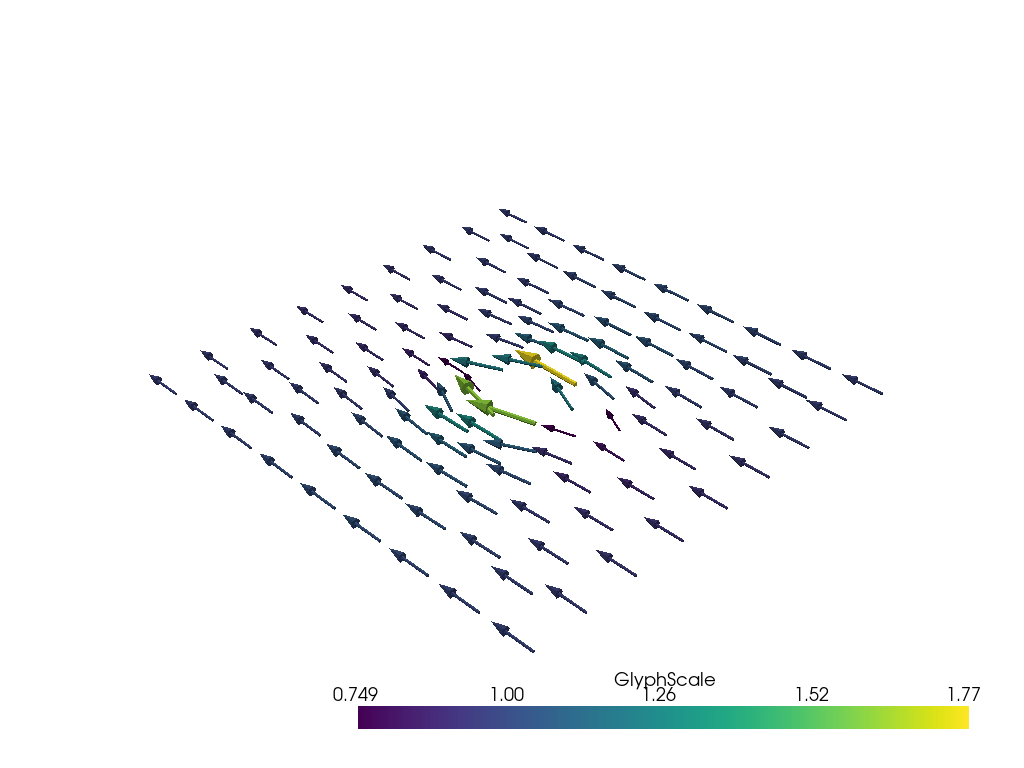

In [67]:

# 8. Plotting with PyVista
# Convert to PyVista grid

topology, cell_types, geometry = dolfinx.plot.vtk_mesh(msh, msh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
# Pad E with zeros for the z-component to make it (n_points, 3)
E_vec = E.x.array.reshape((msh.geometry.x.shape[0], 2))
E_vec_3d = np.zeros((E_vec.shape[0], 3))
E_vec_3d[:, :2] = E_vec
grid.point_data["E"] = E_vec_3d

plotter = pyvista.Plotter()
plotter.add_mesh(grid.glyph(orient="E", factor=0.1), scalars=None)
plotter.show(title="Electric field")